In [1]:
%matplotlib inline
import sys
sys.path.append('..')
from preamble import *
import os
from sklearn.preprocessing import OneHotEncoder

- 도메인 전문가는 초기 데이터에서 더 유용한 특성을 선별하는 데 많은 도움을 줄 수 있음

- 뉴욕시티 자전거 대여 데이터를 사용한 문제
  - https://www.citibikenyc.com/system-data
  - 문제
    - 데이터: 2015년 8월 한달 동안에 대하여 3시간 단위로 앤디 집 앞에 있는 자전거 대여 횟수
    - 특정 날짜와 시간에 앤디 집 앞에 있는 자전거를 사람들이 얼마나 대여하는지 예측
    - 앤디가 빌릴 수 있는 자전거가 남아 있는지 예측

In [4]:
citibike = mglearn.datasets.load_citibike()
print("citibike.data.shape:", citibike.shape)
print(type(citibike))

citibike.data.shape: (248,)
<class 'pandas.core.series.Series'>


In [5]:
print("Citibike data:\n{}".format(citibike.head()))

Citibike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


In [6]:
plt.figure(figsize=(10, 3))

xticks = pd.date_range(
    start=citibike.index.min(), 
    end=citibike.index.max(),
    freq='D'
)

print(xticks)

DatetimeIndex(['2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31'],
              dtype='datetime64[ns]', freq='D')


Text(0,0.5,'Rentals')

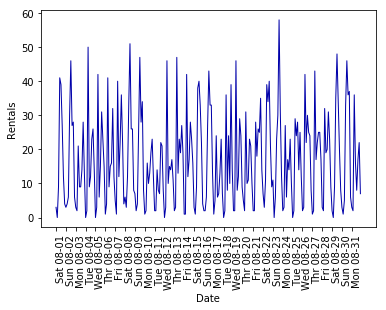

In [7]:
week = ["Sun", "Mon", "Tue", "Wed", "Thr", "Fri", "Sat"]
xtick_name = [week[int(w)] + d for w, d in zip(xticks.strftime("%w"), xticks.strftime(" %m-%d"))]

plt.xticks(xticks, xtick_name, rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

- 24시간 간격으로 낮과 밤에 따라 자전거 대여 횟수에 확연한 차이가 있음
- 주중과 주말의 패턴도 차이가 있음

- 시계열 데이터를 이용한 예측 작업
  - 과거 데이터에서 학습하여 미래를 예측하는 방식
- 데이터 크기
  - 훈련 데이터: 23일 치 - 23 * 8 = 184개
  - 테스트 데이터: 8일 치 - 8 * 8 = 64
  - Note: 24 / 3 = 8

In [9]:
# extract the target values (number of rentals)
y = citibike.values
# convert to POSIX time by dividing by 10**9
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9

In [10]:
print(X[0], y[0])
print(X[1], y[1])
print(X[2], y[2])
print()

print(X.shape)
print(y.shape)

[1438387200] 3
[1438398000] 0
[1438408800] 9

(248, 1)
(248,)


In [11]:
# use the first 184 data points for training, the rest for testing
n_train = 184

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    
    # also split the target array 
    y_train, y_test = target[:n_train], target[n_train:]

    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

Test-set R^2: -0.04


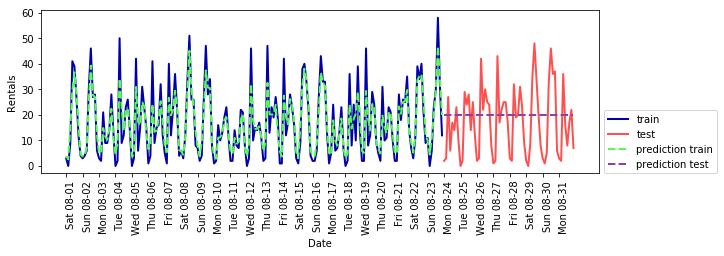

In [12]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

- 훈련 데이터에 대한 예측은 정확
- 테스트 데이터에 대한 예측은 실패
  - $R^2$=-0.04
  - 테스트 데이터들은 훈련 데이터보다 모두 뒤에 있음
  - RandomForestRegressor는 훈련 데이터 특성 범위 밖으로 Extrapolation할 수 없음
  
- 해결 방법 (전문가 지식)
  - 훈련 데이터 특성에서 날짜 정보 (시간의 흐름 정보) 제외
  - 우선 시각 정보만 활용 (3시간 단위)

[0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], [18], [21], [0], [3], [6], [9], [12], [15], 

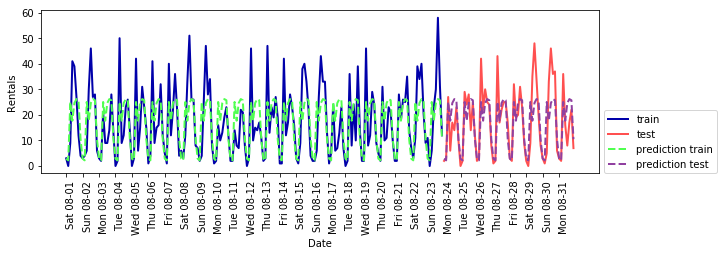

In [13]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
for i in range(len(X_hour)):
    print(X_hour[i], end=", ")
print()
print()
print(X_hour.shape)
print()
eval_on_features(X_hour, y, regressor)

- 위 결과에서 시각에 따른 패턴 예측은 비교적 정확
  - $R^2$=0.6
  - 하지만, 주간 및 주말에 따른 패턴은 예측하지 못하고 있음<br/><br/>
  
 
- 해결 방법
  - 요일 정보를 훈련 데이터에 추가

(248, 1)
(248, 1)

[5 0], [5 3], [5 6], [5 9], [ 5 12], [ 5 15], [ 5 18], [ 5 21], [6 0], [6 3], [6 6], [6 9], [ 6 12], [ 6 15], [ 6 18], [ 6 21], [0 0], [0 3], [0 6], [0 9], [ 0 12], [ 0 15], [ 0 18], [ 0 21], [1 0], [1 3], [1 6], [1 9], [ 1 12], [ 1 15], [ 1 18], [ 1 21], [2 0], [2 3], [2 6], [2 9], [ 2 12], [ 2 15], [ 2 18], [ 2 21], [3 0], [3 3], [3 6], [3 9], [ 3 12], [ 3 15], [ 3 18], [ 3 21], [4 0], [4 3], [4 6], [4 9], [ 4 12], [ 4 15], [ 4 18], [ 4 21], [5 0], [5 3], [5 6], [5 9], [ 5 12], [ 5 15], [ 5 18], [ 5 21], [6 0], [6 3], [6 6], [6 9], [ 6 12], [ 6 15], [ 6 18], [ 6 21], [0 0], [0 3], [0 6], [0 9], [ 0 12], [ 0 15], [ 0 18], [ 0 21], [1 0], [1 3], [1 6], [1 9], [ 1 12], [ 1 15], [ 1 18], [ 1 21], [2 0], [2 3], [2 6], [2 9], [ 2 12], [ 2 15], [ 2 18], [ 2 21], [3 0], [3 3], [3 6], [3 9], [ 3 12], [ 3 15], [ 3 18], [ 3 21], [4 0], [4 3], [4 6], [4 9], [ 4 12], [ 4 15], [ 4 18], [ 4 21], [5 0], [5 3], [5 6], [5 9], [ 5 12], [ 5 15], [ 5 18], [ 5 21], [6 0], [6 3], [6 6], 

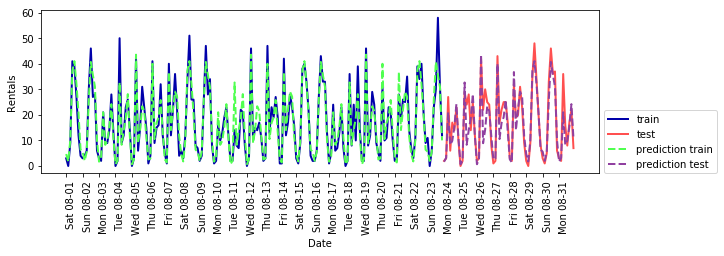

In [14]:
a = citibike.index.dayofweek.values.reshape(-1, 1)
b = citibike.index.hour.values.reshape(-1, 1)
print(a.shape)
print(b.shape)
print()

X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])

for i in range(len(X_hour_week)):
    print(X_hour_week[i], end=", ")
print()
print()
print(X_hour_week.shape)
print()

eval_on_features(X_hour_week, y, regressor)

- 예측의 결과가 비교적 정확
  - $R^2$=0.84
  
  
  
- RandomForestRegressor가 아닌 선형 모델 사용

Test-set R^2: 0.13


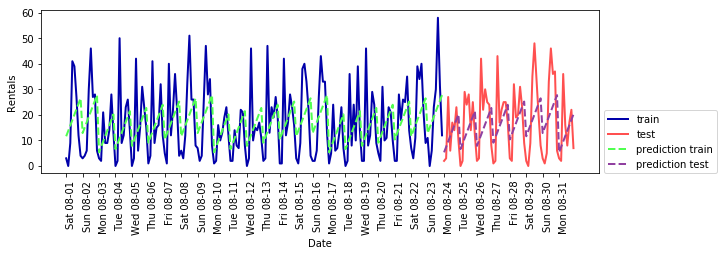

In [15]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

- LinearRegression 모델의 학습 결과가 좋지 않음
  - 요일과 시간이 정수로 인코딩되어 있어서 자동으로 연속형 변수로 해석됨
  - 시간을 선형 함수로만 학습하기 때문에 하루에서 시간이 흐를수록 결과값이 증가됨
  - 훈련 데이터 특성을 이산형으로 변형
     - OneHotEncorder 사용

In [18]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

print(X_hour_week_onehot[0])
print(X_hour_week_onehot[1])
print(X_hour_week_onehot[2])
print()
print(X_hour_week_onehot.shape)
print()

[0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

(248, 15)

